In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import warnings

from matplotlib import transforms

In [2]:
SECONDS_IN_YEAR = 60*60*24*365 #s
convert = lambda x: x * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

AREA_of_EARTH = 510.1 * 1e6 #million km²

# data_path = "F:\\Local Data\\ClimateBench\\"
data_path = '../'
# data_path = '/Users/watson-parris/Local Data/ClimateBench/train_val_updated/'

# Only future scenarios for now
inputs = glob(data_path + "inputs_s*.nc")

def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).mean(['latitude', 'longitude'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).sum(['latitude', 'longitude'])


In [3]:
print(inputs)

['../inputs_ssp245.nc', '../inputs_ssp126.nc', '../inputs_ssp370.nc', '../inputs_ssp370-lowNTCF.nc', '../inputs_ssp585.nc']


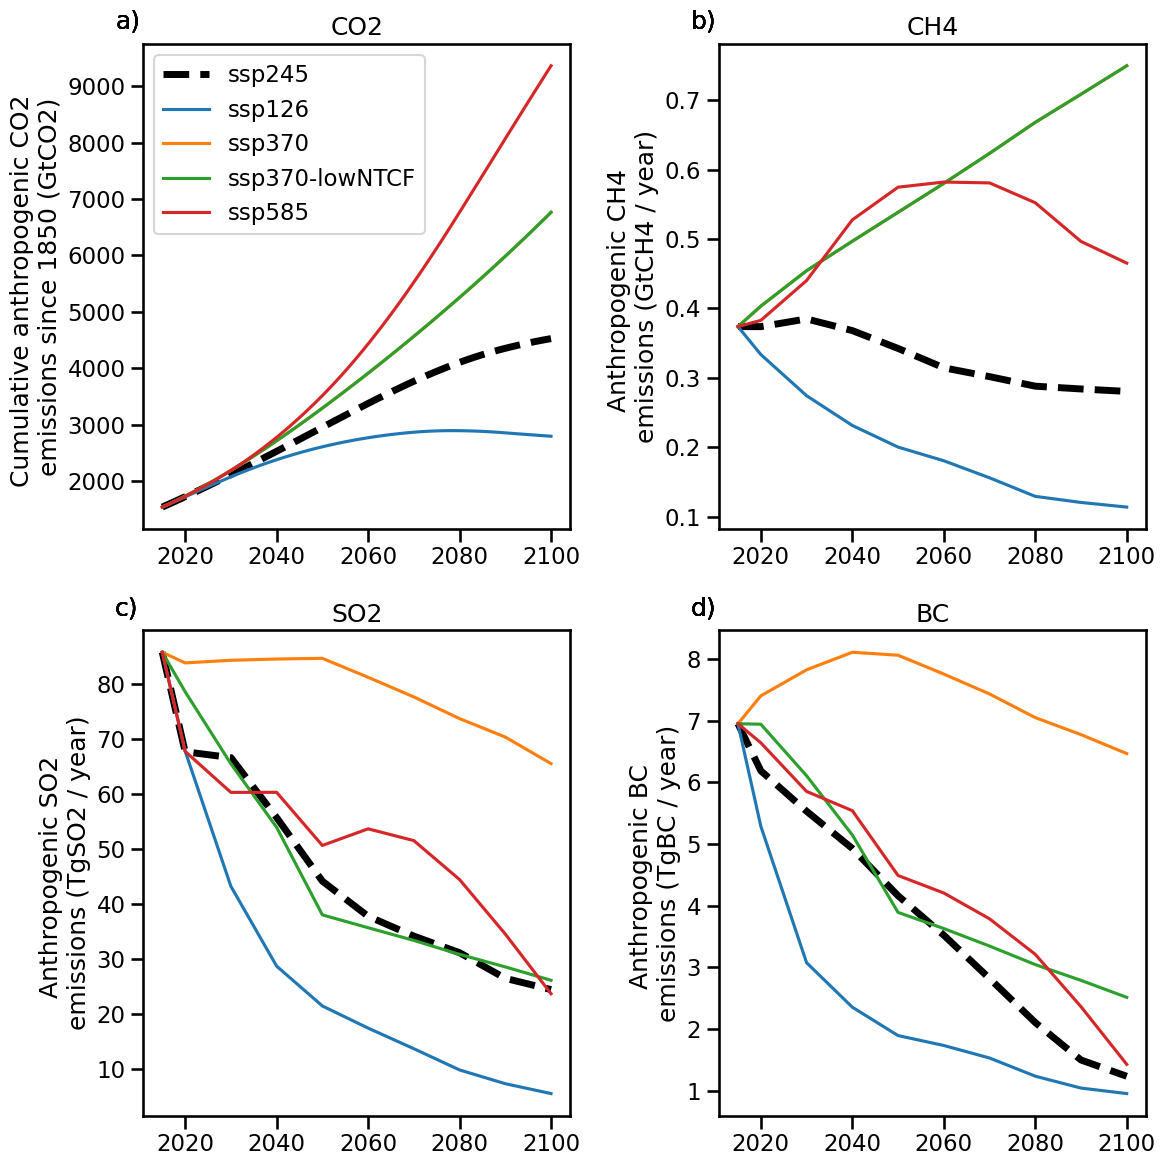

In [4]:

def add_label(label, ax=None, fig=None, fontsize='medium', va='bottom', x=0., y=1., **kwargs):
    if ax is None:
        ax = plt.gca()
    if fig is None:
        fig = plt.gcf()
    trans = transforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(x, y, label, transform=ax.transAxes + trans,
            fontsize=fontsize, va=va, **kwargs)
    
# for label, ax in zip(['a)', 'b)'], [ax1, ax2]):
#     # label physical distance to the left and up:
#     add_label(ax, label)


    
with sns.plotting_context("talk"):

    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    for input in inputs:
        # label=input.split('_')[2][:-3]
        label = input.split('_')[1].split('.')[0]
        if label.startswith('ssp245-'):
            continue # Skip these idealised inputs 
        X = xr.open_dataset(input)
        x = range(2015, 2101)
        
        kwargs = {}
        if label == "ssp245":
            kwargs['color'] = 'black'
            kwargs['ls'] = '--'
            kwargs['lw'] = '5'
        axes[0, 0].plot(x, X['CO2'], label=label, **kwargs)
        axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
        add_label('a)', axes[0, 0])
        axes[0, 1].plot(x, X['CH4'], label=label, **kwargs)
        axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
        add_label('b)', axes[0, 1])
        # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
        axes[1, 0].plot(x, convert(global_sum(X['SO2']*AREA_of_EARTH*1000*100)), label=label, **kwargs)
        axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (TgSO2 / year)")
        add_label('c)', axes[1, 0])
        axes[1, 1].plot(x, convert(global_sum(X['BC']*AREA_of_EARTH*1000*100)), label=label, **kwargs)
        axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (TgBC / year)")
        add_label('d)', axes[1, 1])

    axes[0, 0].set_title('CO2')
    axes[0, 1].set_title('CH4')
    axes[1, 0].set_title('SO2')
    axes[1, 1].set_title('BC')
    axes[0, 0].legend()
    plt.tight_layout()
    
    plt.savefig("Figure_1.pdf")

In [5]:
all_inputs = glob(data_path + "inputs_*.nc")
global_means = {}

def global_total(da):
    if 'latitude' in da.coords:
        if da.name in ['CO2', 'CH4', 'tas']:
            return global_mean(da)
        else:
            return convert(global_sum(da*AREA_of_EARTH*1000*100))
    else:
        return da

# for inp in glob(data_path + "inputs_*.nc"):
#     label=inp.split('_')[3][:-3]
#     X = xr.open_dataset(inp)
#     Y = xr.open_dataset(data_path + f"outputs_{label}.nc")
# #     print(X.coords)
#     print(label)
# #     if label == "hist-aer":
# #         X = X.rename_vars({"CO4": "CO2"})
#     if 'lat' in X.coords:
#         X = X.rename({'lat': 'latitude', 'lon': 'longitude'})
#     if 'lat' in Y.coords:
#         Y = Y.rename({'lat': 'latitude', 'lon': 'longitude'})

#     if label == "abrupt-4xCO2":
#         X = X.sel(time=slice(None, None, 5))
#     X['tas'] = Y['tas'].mean('member')
    
#     global_means[label] = X.map(global_total).to_pandas()
import os

for inp in glob(data_path + "inputs_*.nc"):
    filename = os.path.basename(inp)  # Get the filename from the full path
    label = filename.split('_')[1].split('.')[0]  # Split the filename to extract the label
    
    X = xr.open_dataset(inp)
    Y = xr.open_dataset(data_path + f"outputs_{label}.nc")
    
    print(label)
    
    # if label == "hist-aer":
    #     X = X.rename_vars({"CO4": "CO2"})
    if 'lat' in X.coords:
        X = X.rename({'lat': 'latitude', 'lon': 'longitude'})
    if 'lat' in Y.coords:
        Y = Y.rename({'lat': 'latitude', 'lon': 'longitude'})

    if label == "abrupt-4xCO2":
        X = X.sel(time=slice(None, None, 5))
    X['tas'] = Y['tas'].mean('member')
    
    global_means[label] = X.map(global_total).to_pandas()

# print(global_means)


ssp245
1pctCO2
abrupt-4xCO2
historical
hist-GHG
hist-aer
ssp126
ssp370
ssp370-lowNTCF
ssp585


In [6]:
df = pd.concat(global_means, names=['scenario', 'time']).reset_index()

In [7]:
idealised = 'Idealised'
scenario = 'Scenario'
historical = 'Historical'

name_map = {'1pctCO2': idealised, 'abrupt-4xCO2': idealised, 'hist-aer': idealised, 'hist-GHG': idealised, 'ssp245-aer': idealised, 'ssp245-GHG': idealised,
            'historical': historical, 
            'ssp126': scenario, 'ssp245': scenario, 'ssp370-lowNTCF': idealised, 'ssp370': scenario, 'ssp585': scenario}
df['Type'] = df.reset_index().apply(lambda x: name_map[x['scenario']], axis=1)

In [8]:
plot_df = df.rename(columns={"CO2": "Cumulative CO2 (GtCO2)",
                             "SO2": "SO2 (TgSO2 / year)",
                             "BC": "BC (TgBC / year)",
                             "CH4": "CH4 (GtCH4 / year)" }).drop(columns=['scenario', 'time', 'quantile', 'tas'])

/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

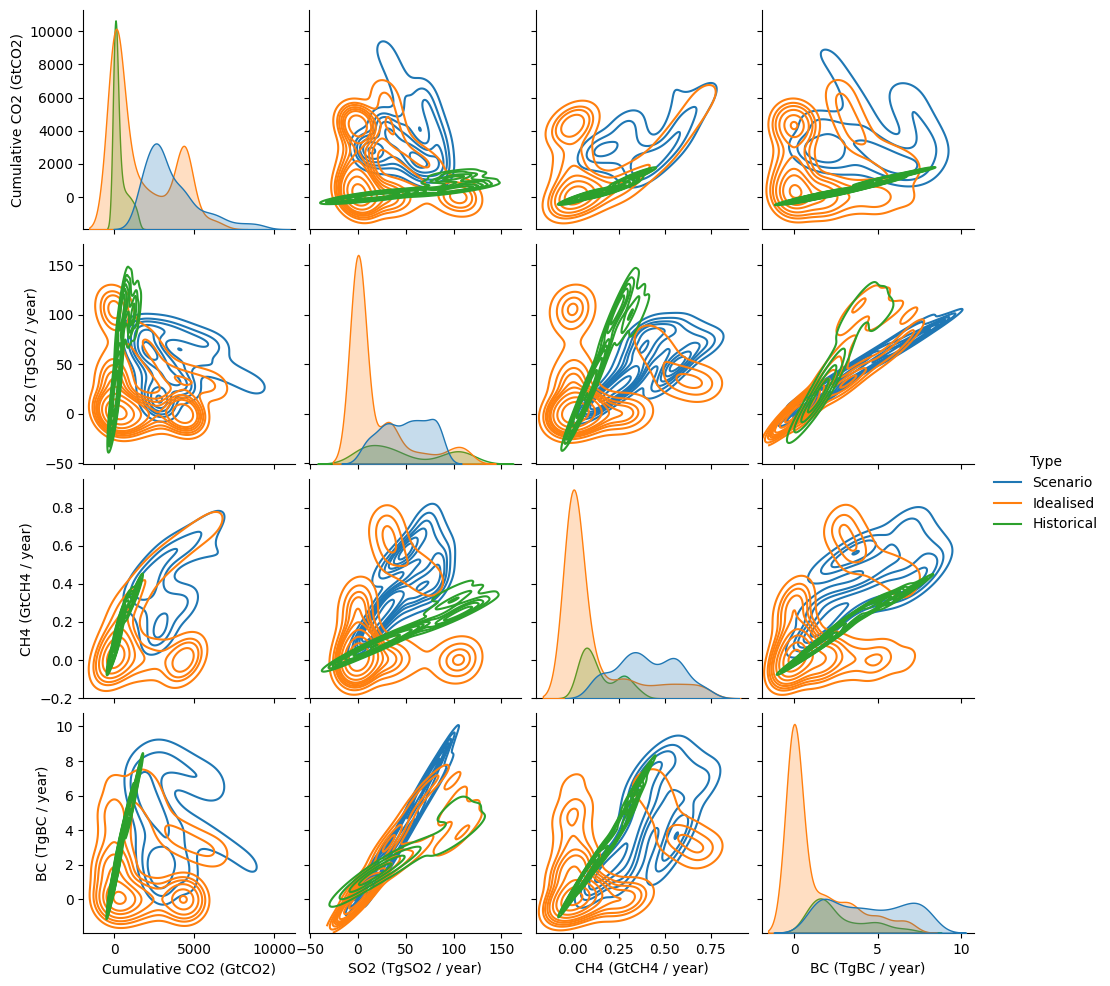

In [9]:
sns.pairplot(plot_df, hue="Type", kind='kde')
# Includes every 5th year from the 4xCo2 experiment since it's roughly 5 times longer than the others

/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

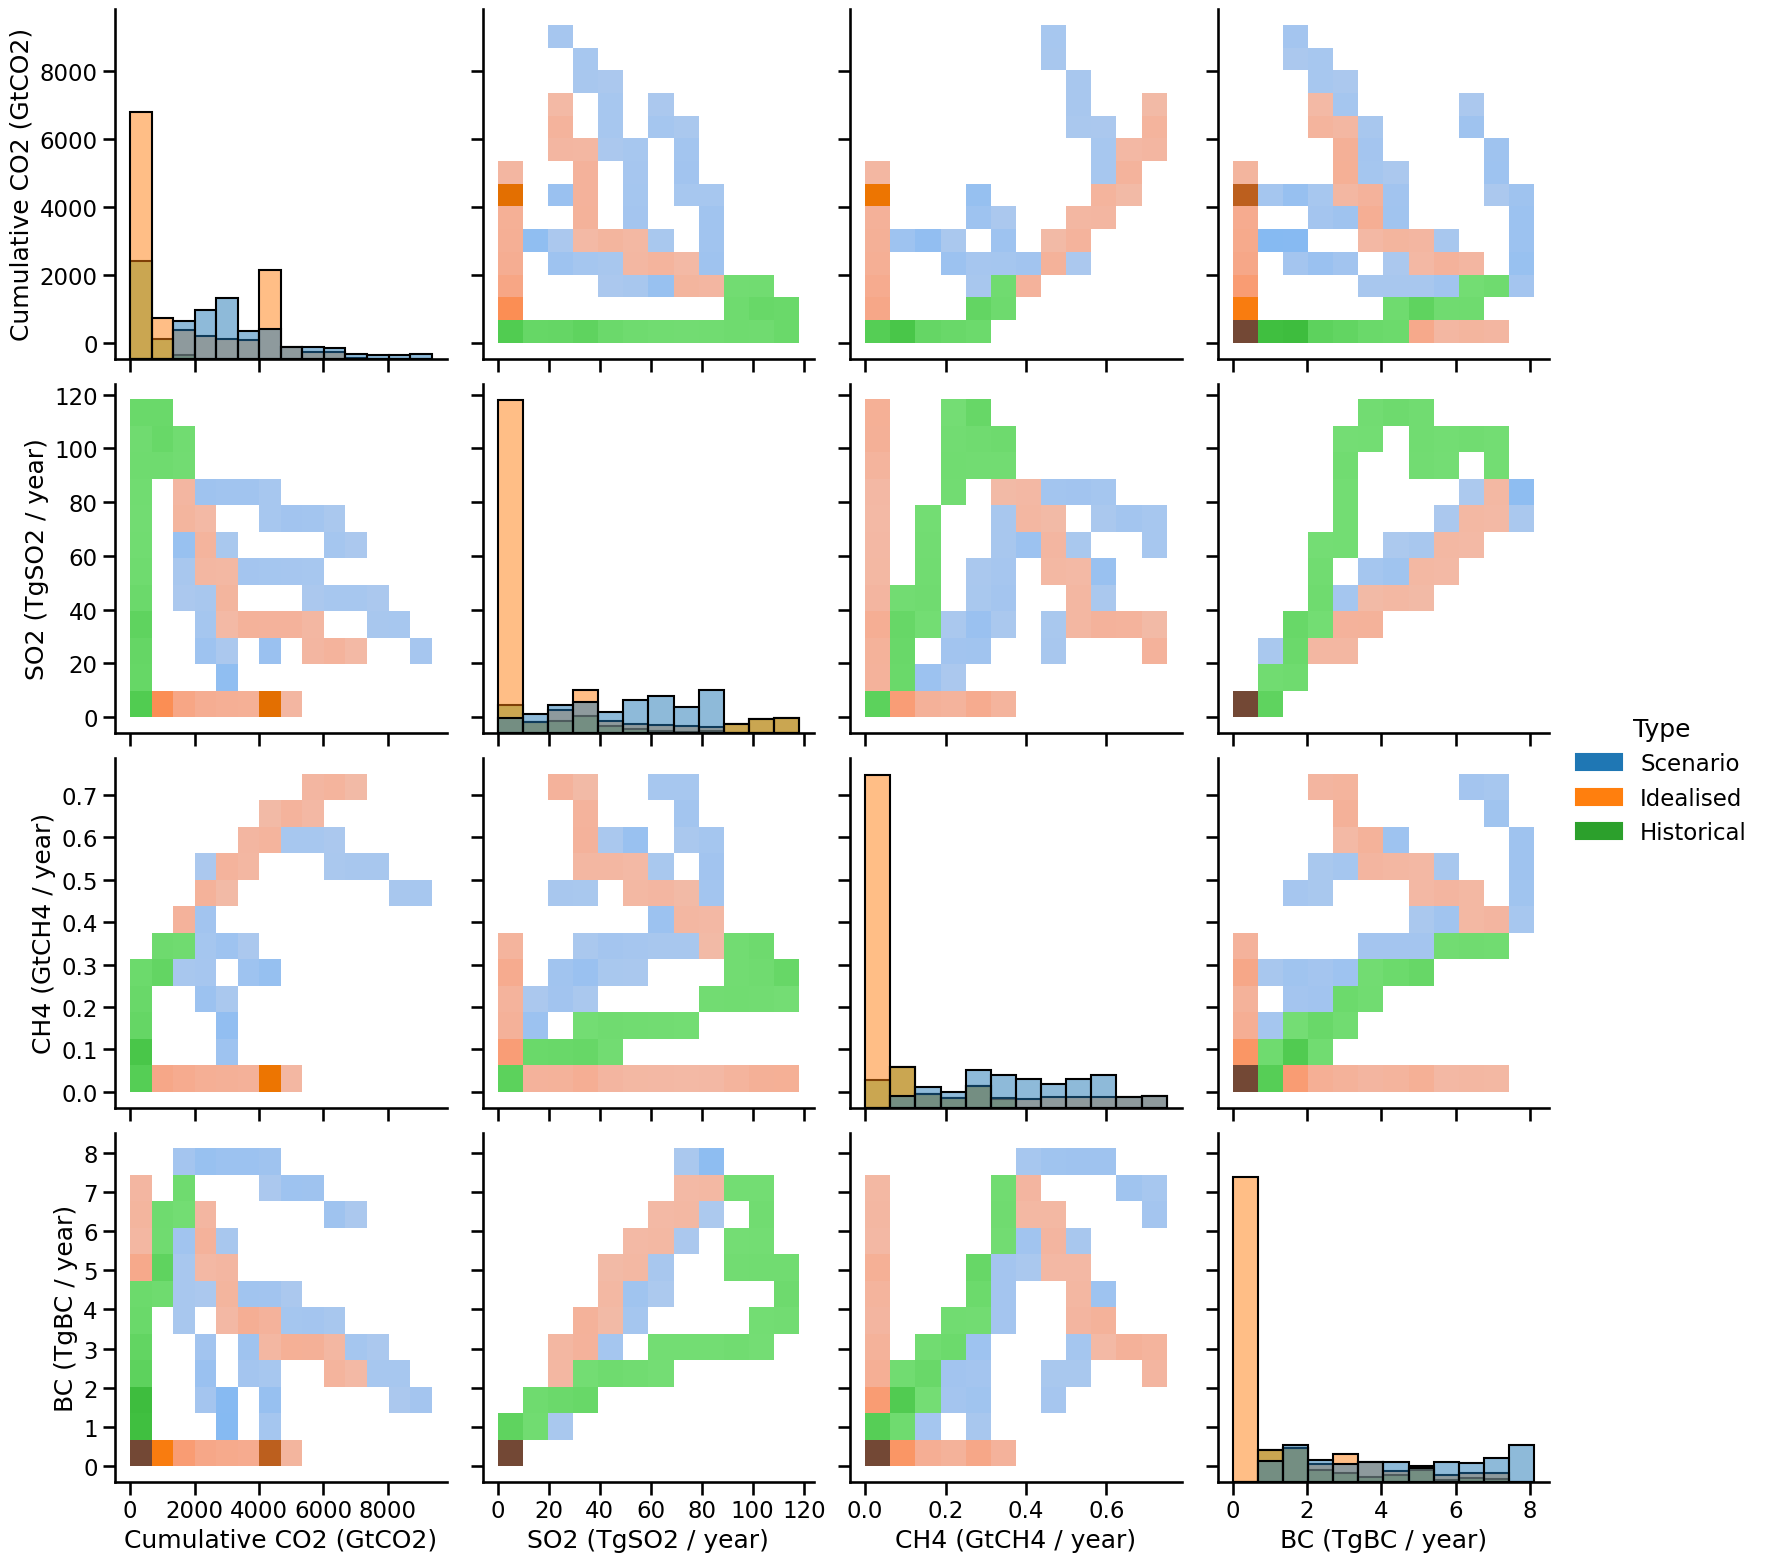

In [10]:
with sns.plotting_context("talk"):

#     fig = plt.figure(figsize=(12,12))

    sns.pairplot(plot_df, hue="Type", kind='hist', height=4)
    
    plt.savefig("Figure_A1.pdf")

In [11]:
# Get one combined historical + ssp585 timeseries for now
X = xr.open_mfdataset([data_path + 'inputs_historical.nc', data_path + 'inputs_ssp245.nc']).compute()

Y = xr.open_dataset(data_path + 'outputs_ssp245.nc')

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

In [12]:
# Leave the projection as PlateCarree for dev then Mollweide for final plots (it's slow!)
proj = ccrs.Mollweide() 
# proj = ccrs.PlateCarree()

# Alternative approaches....:
# Sort the coordinates so that contourf works properly (pcolormesh takes forever in this projection)
# X.coords['longitude'] = (X.coords['longitude'] + 180) % 360 - 180
# X = X.sortby(X.longitude)
# Try adding a cyclic point, but losses the xarray goodness..
# from cartopy.util import add_cyclic_point 

In [13]:
# with sns.plotting_context("talk"):

#     fig = np.log(X["SO2"].sel(time=[1850, 1970, 2020, 2100])).plot.pcolormesh(col='time',col_wrap=2, vmin=-27, vmax=-20,  transform=ccrs.PlateCarree(),
#                                                                               subplot_kws=dict(projection=proj), figsize=(18, 8),
#                                                                               cbar_kwargs=dict(label='Log anthropogenic SO2 emissions (log kg / m2 / s)'))


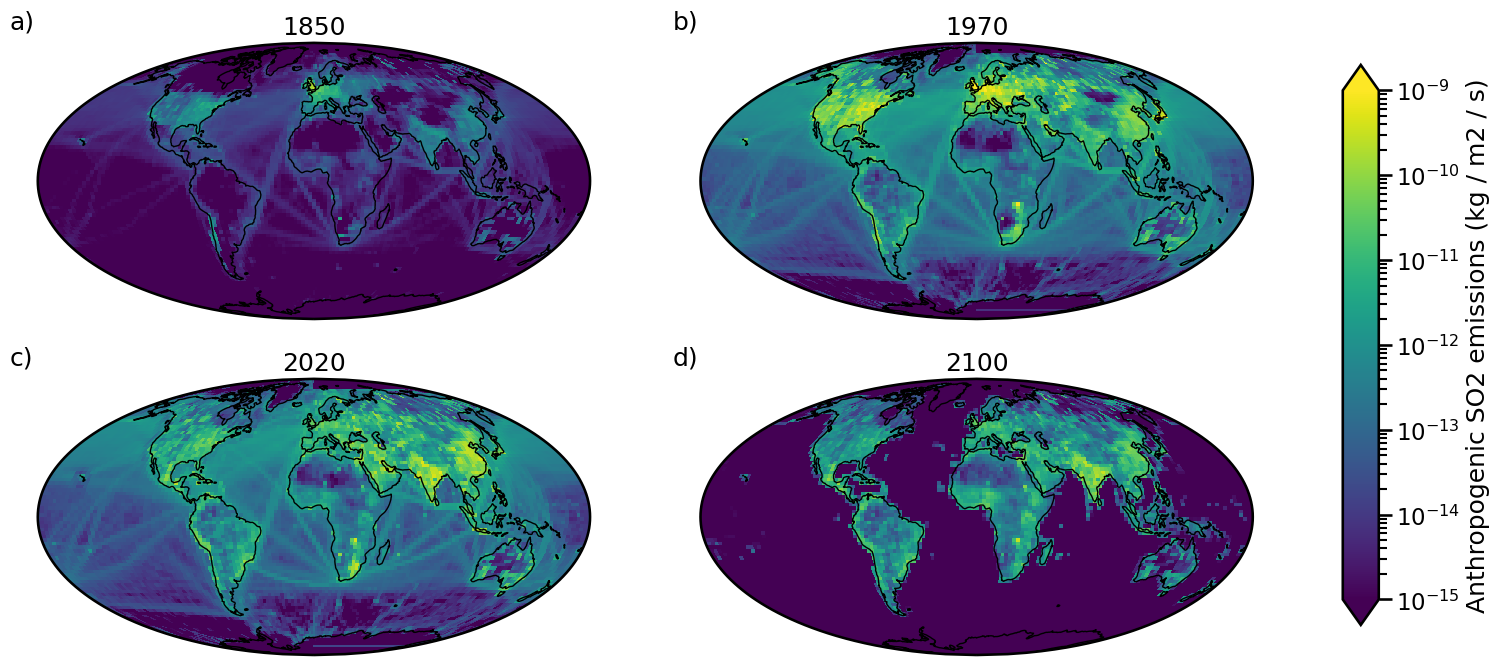

In [14]:
import matplotlib
with sns.plotting_context("talk"):

    norm = matplotlib.colors.LogNorm(1e-17, 1e-10, clip=True)
    norm = matplotlib.colors.LogNorm(1e-15, 1e-9, clip=True)
    fig = plt.figure(figsize=(18, 8))
    plt.subplot(221, projection=proj)
    X["SO2"].sel(time=1850).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('1850')
    add_label('a)')

    plt.subplot(222, projection=proj)
    X["SO2"].sel(time=1970).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('1970')
    add_label('b)')

    plt.subplot(223, projection=proj)
    X["SO2"].sel(time=2020).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('2020')
    add_label('c)')

    plt.subplot(224, projection=proj)
    m=X["SO2"].sel(time=2100).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('2100')
    add_label('d)')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax, extend='both')
    cbar.set_label('Anthropogenic SO2 emissions (kg / m2 / s)')
    
    plt.savefig("Figure_2.pdf")

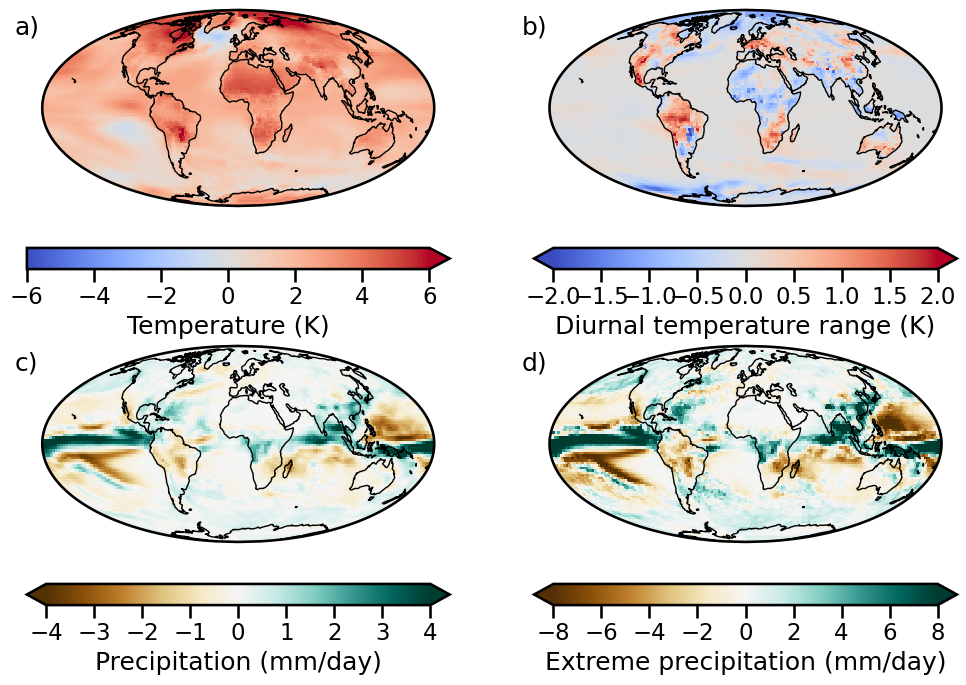

In [15]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=6)

with sns.plotting_context("talk"):

    fig = plt.figure(figsize=(12, 8))
    plt.subplot(221, projection=proj)
    Y["tas"].sel(time=2100, member=1).plot(cmap="coolwarm", vmax=6, transform=ccrs.PlateCarree(), add_labels=False,
                                  cbar_kwargs={"label":"Temperature (K)", "orientation":'horizontal'})
    plt.gca().coastlines()
    add_label('a)', y=0.8)
 
    plt.subplot(222, projection=proj)
    Y["diurnal_temperature_range"].sel(time=2100, member=1).plot(cmap="coolwarm", vmax=2, transform=ccrs.PlateCarree(), add_labels=False,
                                                      cbar_kwargs={"label":"Diurnal temperature range (K)", "orientation":'horizontal'})
    plt.gca().coastlines()
    add_label('b)', y=0.8)

    plt.subplot(223, projection=proj)
    #  Convert precip to mm/day
    (Y["pr"].sel(time=2100, member=1)).plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-4, vmax=4, add_labels=False,
                                 cbar_kwargs={"label":"Precipitation (mm/day)", "orientation":'horizontal'})
    plt.gca().coastlines()
    add_label('c)', y=0.8)

    plt.subplot(224, projection=proj)
    (Y["pr90"].sel(time=2100, member=1)).plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-8, vmax=8, add_labels=False,
                                   cbar_kwargs={"label":"Extreme precipitation (mm/day)", "orientation":'horizontal'})
    plt.gca().coastlines()
    add_label('d)', y=0.8)

    plt.savefig("Figure_3.pdf")

In [16]:
# variables = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']
# rf_predictions = xr.open_dataset(data_path + "/baseline_models/" + 'outputs_ssp245_prediction_ESEm.nc').swap_dims(sample='time')
# rf_predictions = rf_predictions.assign_coords(time=rf_predictions.time+1)  # I don't really know why this is off...
# linear_predictions = xr.open_dataset(data_path + 'outputs_ssp245_prediction_pattern2.nc')
# nn_predictions = xr.merge([{v: xr.open_dataarray(data_path + "/baseline_models/" + "outputs_ssp245_predict_{}.nc".format(v))} for v in variables])
# gp_predictions = xr.merge([{v: xr.open_dataarray(data_path + "/baseline_models/" + "climatebench-gp-posterior-mean-{}-test-2019-2100.nc".format(v))} for v in variables])

variables = ['tas', 'dtr', 'pr', 'pr90']

# Assuming 'outputs_ssp245_prediction_ESEm.nc' exists in the 'baseline_models' directory
rf_predictions = xr.open_dataset(data_path + "/baseline_models/outputs_ssp245_prediction_ESEm.nc").swap_dims(sample='time')
rf_predictions = rf_predictions.assign_coords(time=rf_predictions.time+1)

# Assuming 'outputs_ssp245_prediction_pattern2.nc' exists in the main directory
linear_predictions = xr.open_dataset(data_path + 'outputs_ssp245_prediction_pattern2.nc')

# Adjusting file paths for 'outputs_ssp245_predict_{}.nc' format files
nn_predictions = xr.merge([{v: xr.open_dataarray(data_path + "outputs_ssp245_predict_{}.nc".format(v))} for v in variables])

# Adjusting file paths for 'climatebench-gp-posterior-mean-{}-test-2019-2100.nc' format files in 'baseline_models' directory
gp_predictions = xr.merge([{v: xr.open_dataarray(data_path + "/baseline_models/climatebench-gp-posterior-mean-{}-test-2019-2100.nc".format(v))} for v in variables])

# Convert the precip values to mm/day for nn_predictions
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

In [17]:
# Convert the precip values to mm/day
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

In [18]:
models = [linear_predictions, rf_predictions, nn_predictions, gp_predictions, Y.mean('member')]
model_labels = ['Pattern Scaling', 'Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-2, vmax=2), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

In [19]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

In [20]:
for i in range(len(models)):
    if 'diurnal_temperature_range' in models[i].data_vars:
        models[i] = models[i].rename({'diurnal_temperature_range': 'dtr'})

[[<GeoAxes: > <GeoAxes: > <GeoAxes: > <GeoAxes: >]
 [<GeoAxes: > <GeoAxes: > <GeoAxes: > <GeoAxes: >]
 [<GeoAxes: > <GeoAxes: > <GeoAxes: > <GeoAxes: >]
 [<GeoAxes: > <GeoAxes: > <GeoAxes: > <GeoAxes: >]]


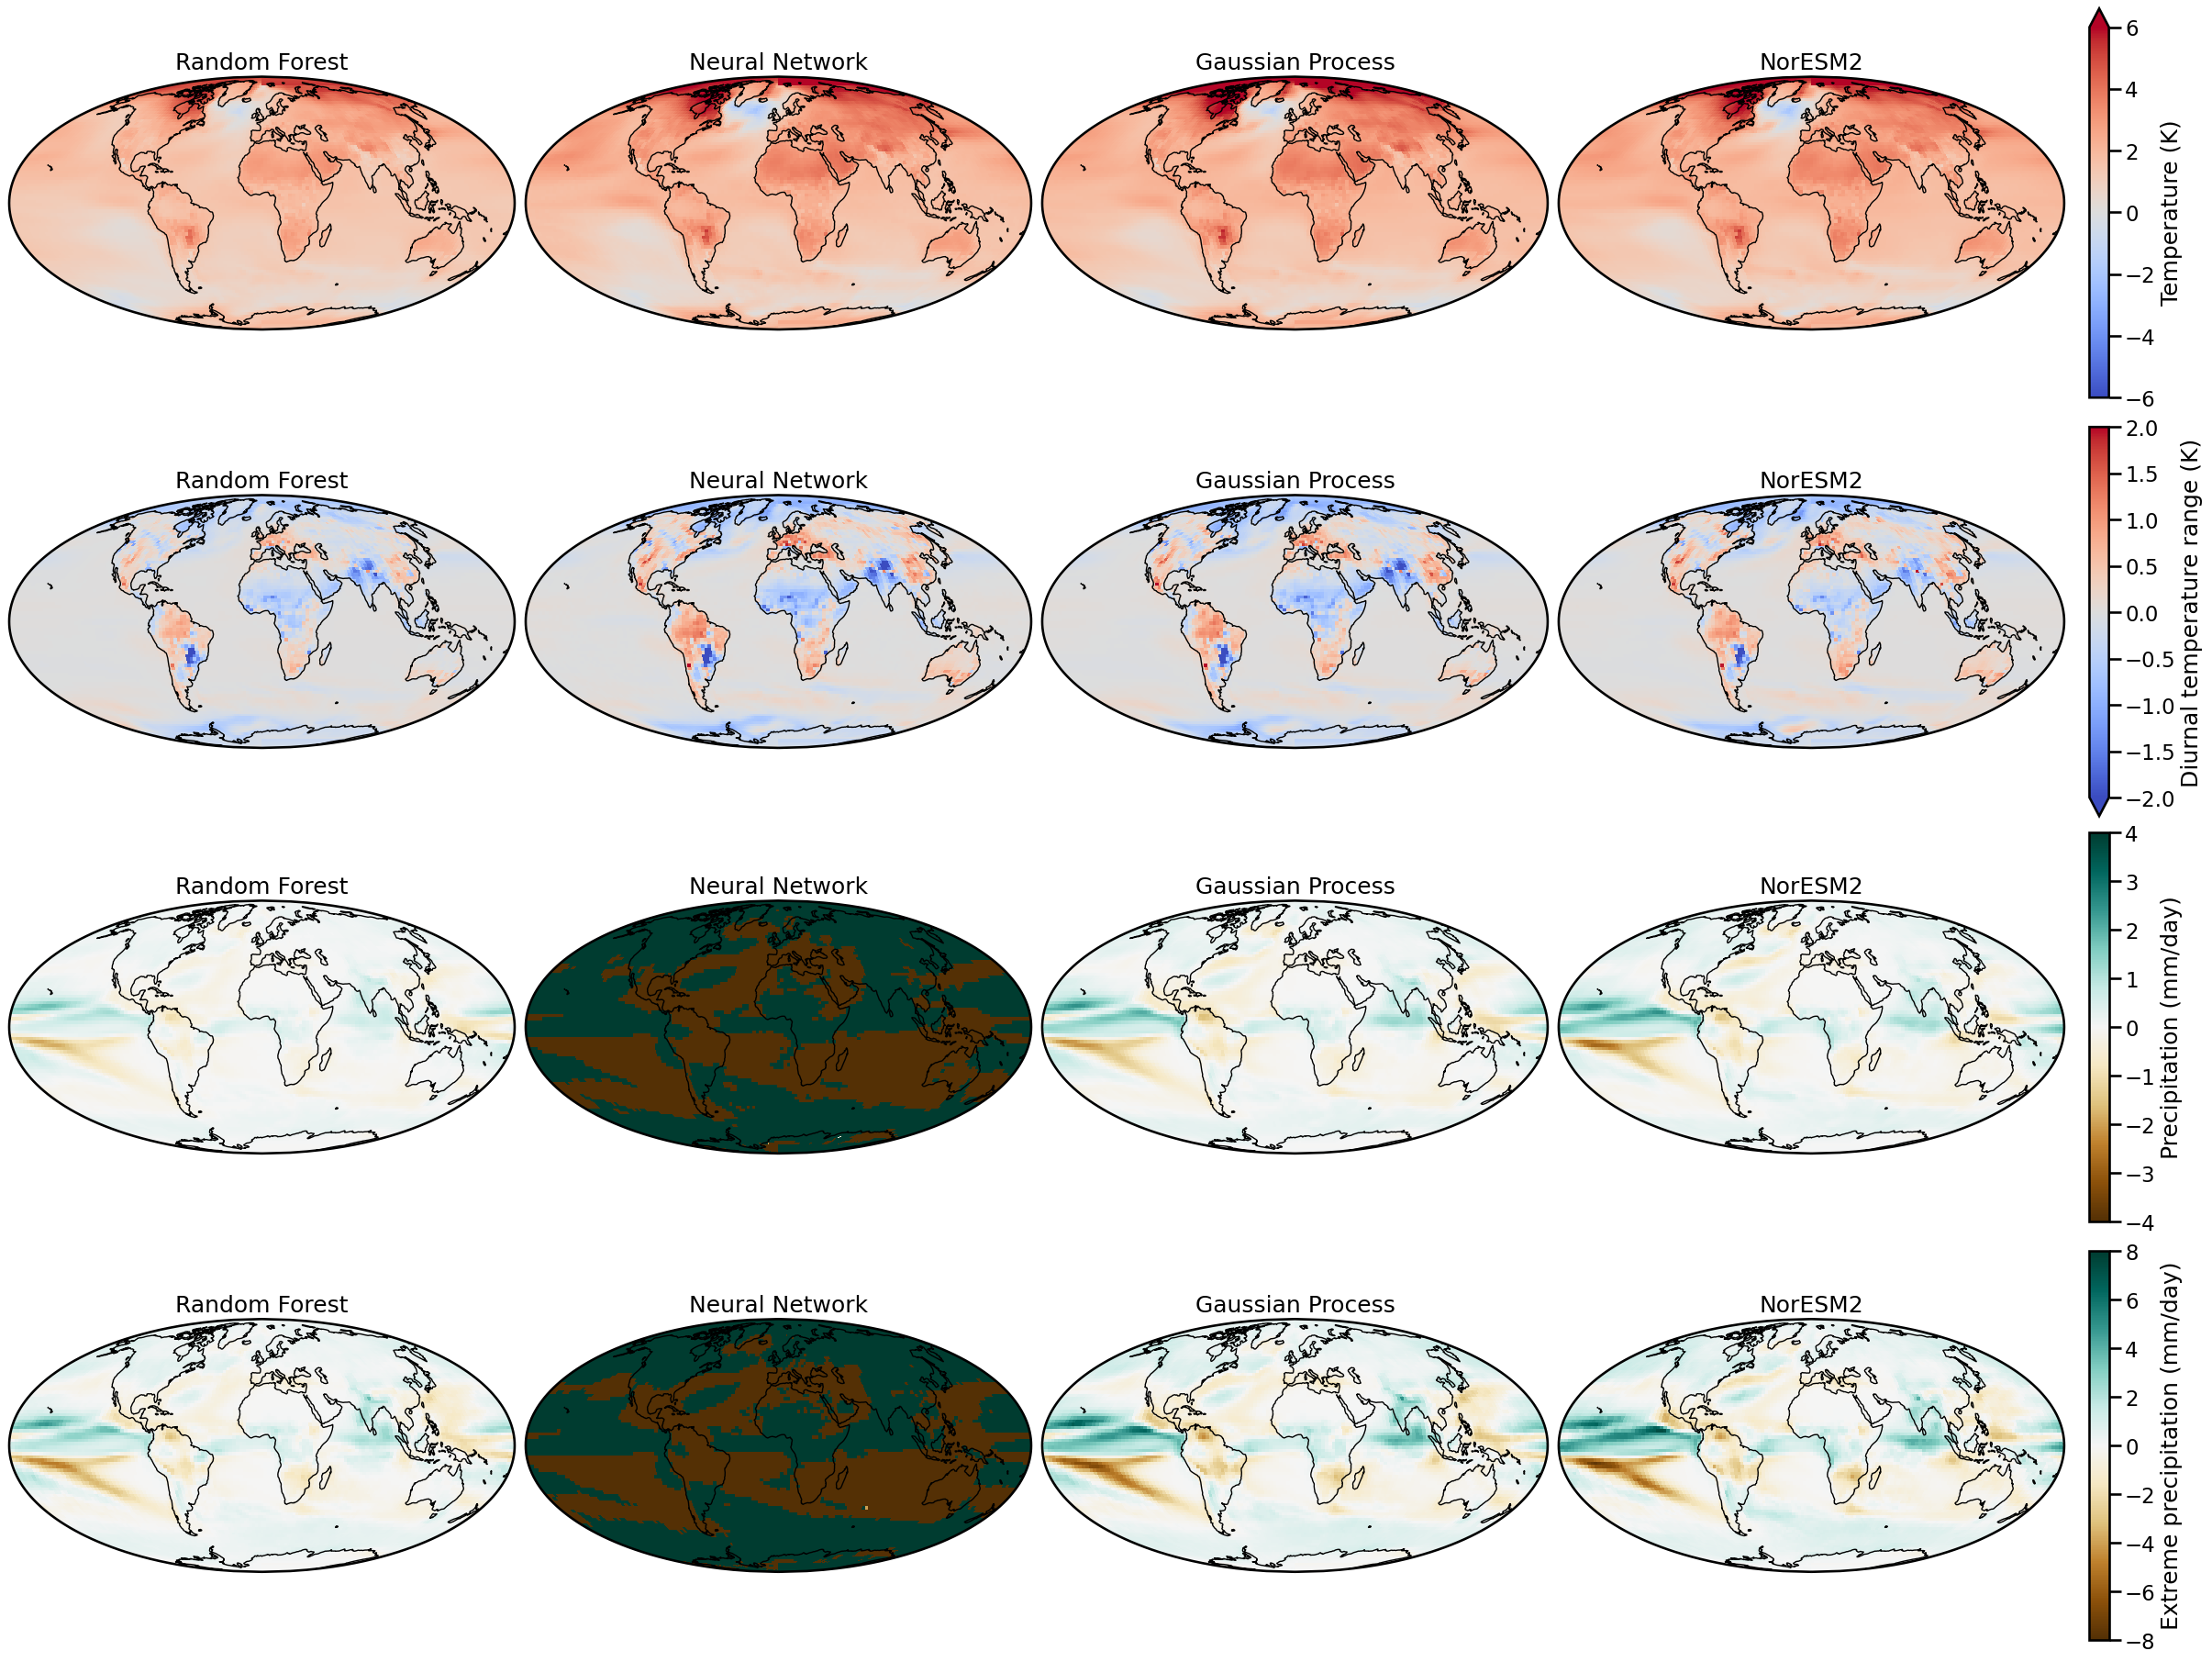

In [21]:
with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 4, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models[1:], model_labels[1:]):
#             if label == 'Temperature (K)':
            ax.set_title(model_label)
            if model_label == 'NorESM2':
                model[var].sel(time=slice(2080, 2100)).mean(['time']).plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else: 
                model[var].sel(time=slice(2080, 2100)).mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            ax.coastlines()
                
    plt.savefig("Figure_A2.pdf")

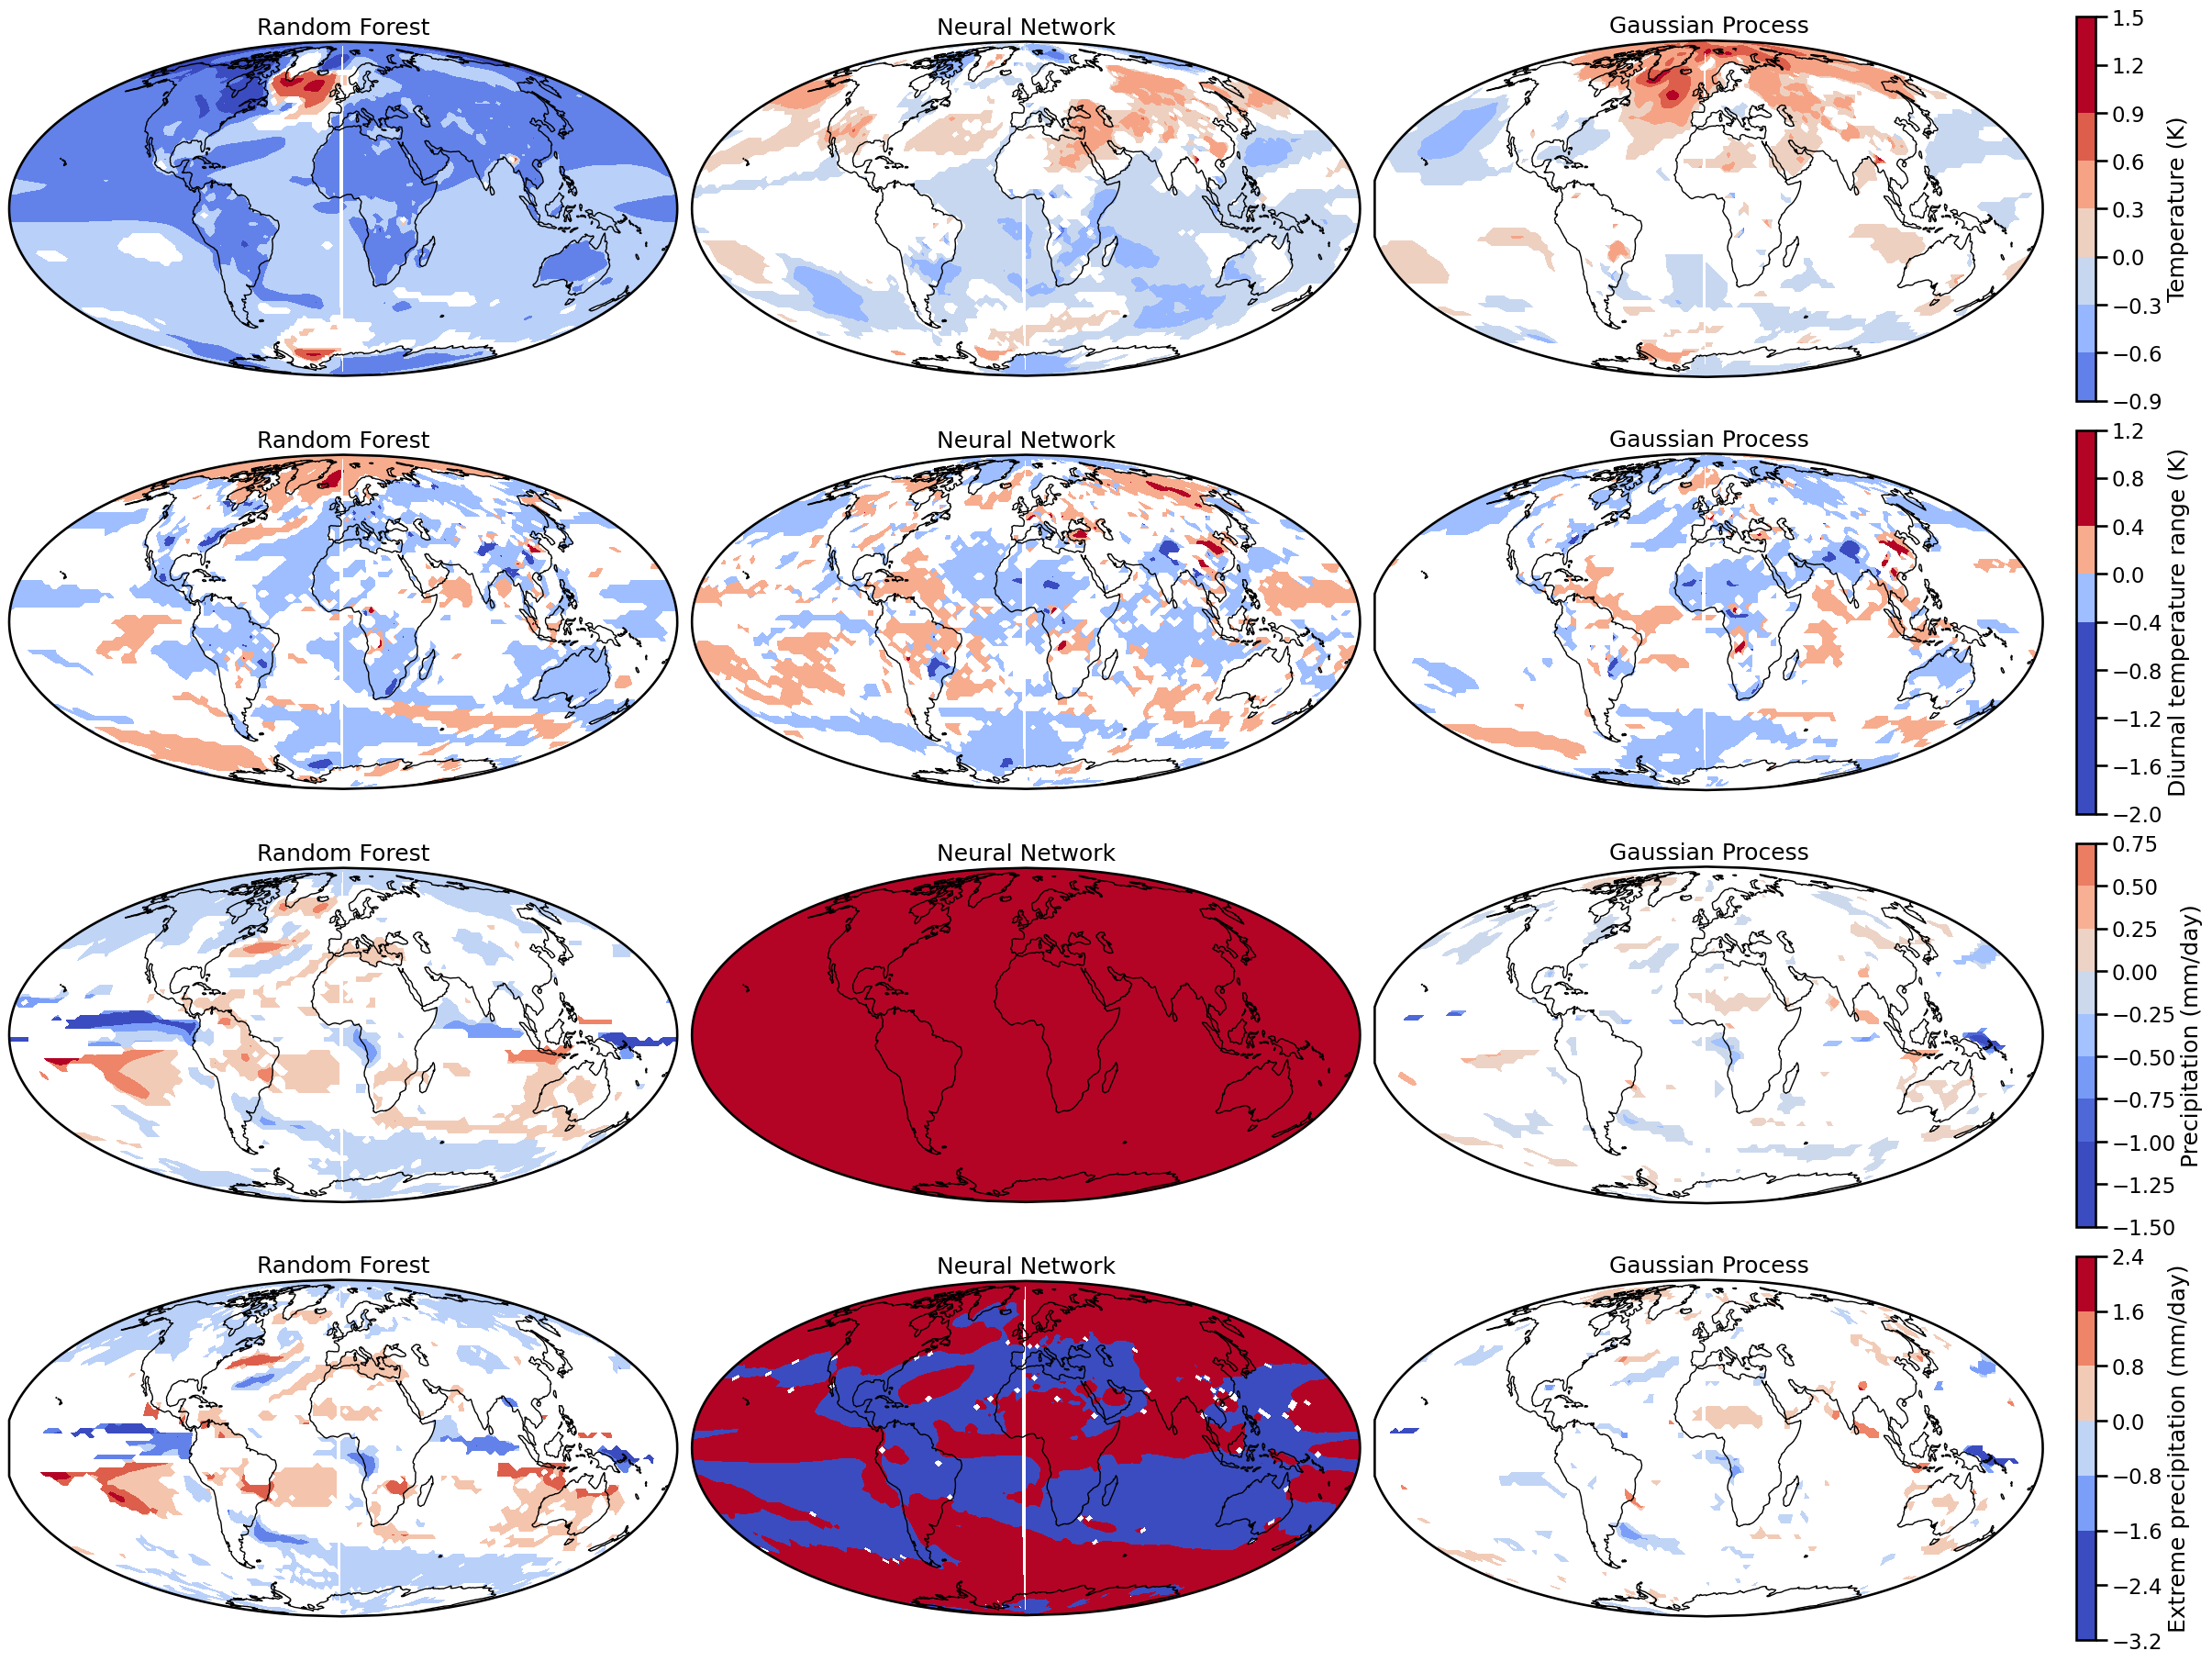

In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
from scipy.stats import ttest_rel

# Assuming models, model_labels, variables, labels are already defined
proj = ccrs.Mollweide()
p_level = 0.05  # Assuming p_level is defined

# Rename 'lat' and 'lon' to 'latitude' and 'longitude' for each model
for model in models:
    for var in model.data_vars:
        if 'lat' in model[var].dims and 'lon' in model[var].dims:
            model[var] = model[var].rename({'lat': 'latitude', 'lon': 'longitude'})

# Colorbar arguments for each variable
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]

with sns.plotting_context("talk"):
    fig, axes = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)

    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models[1:-1], model_labels[1:-1]):
            ax.set_title(model_label)

            # Calculate the difference and mean difference
            diff = (model[var] - models[-1][var]).sel(time=slice(2080, 2100))
            mean_diff = diff.mean('time')

            # Perform t-test
            _, p_values = ttest_rel(diff, np.zeros_like(diff), axis=diff.dims.index('time'))
            
            # Apply mask using xarray's where method
            masked_mean_diff = mean_diff.where(p_values < p_level, np.nan)

            # Plot with masking
            if model_label == 'Gaussian Process':
                cs = ax.contourf(mean_diff.longitude, mean_diff.latitude, masked_mean_diff, transform=ccrs.PlateCarree(), cmap='coolwarm', **kws)
                plt.colorbar(cs, ax=ax, orientation='vertical', label=label)
            else:
                ax.contourf(mean_diff.longitude, mean_diff.latitude, masked_mean_diff, transform=ccrs.PlateCarree(), cmap='coolwarm', **kws)
            
            ax.coastlines()

    plt.savefig("Figure_4.pdf")


In [23]:
#......Original...code....for....the...above....plots
# # proj = ccrs.PlateCarree()
# kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]


# with sns.plotting_context("talk"):

# #     fig = plt.figure()
#     fig, axes = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
#     print(axes)
#     for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
#         for ax, model, model_label in zip(model_axes, models[1:-1], model_labels[1:-1]):
# #             if label == 'Temperature (K)':
#             ax.set_title(model_label)
# #             print(model_label, model)
#             diff = (model[var]-models[-1][var]).sel(time=slice(2080, 2100)) # /models[-1][var]
#             mean_diff = diff.mean('time')
#             _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
#             if model_label == 'Gaussian Process':
#                 mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
#             else:
#                 mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            
#             ax.coastlines()
    
#     plt.savefig("Figure_4.pdf")

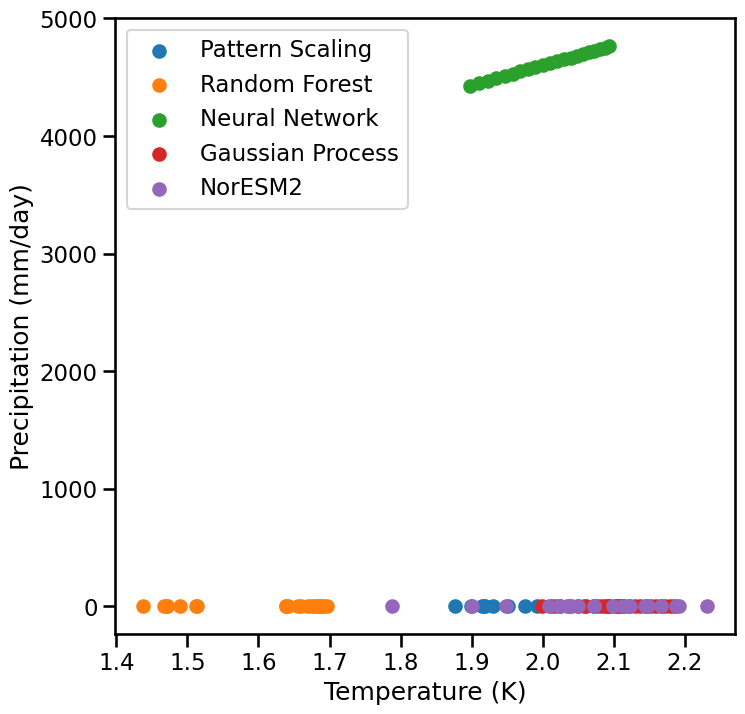

In [24]:
# models = [rf_predictions, nn_predictions, gp_predictions, Y.mean('member')]
# model_labels = ['Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']

def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas'].sel(time=slice(2080, 2100))), global_mean(model['pr'].sel(time=slice(2080, 2100))), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()
                

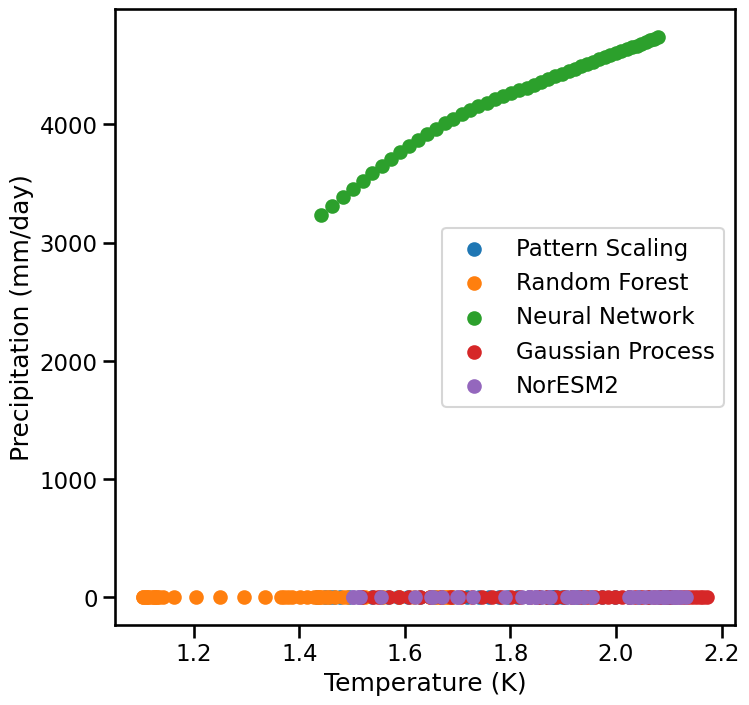

In [25]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas'].sel(time=slice(2050, 2100))).rolling(time=5, center=True).mean(), global_mean(model['pr'].sel(time=slice(2050, 2100))).rolling(time=5, center=True).mean(), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()

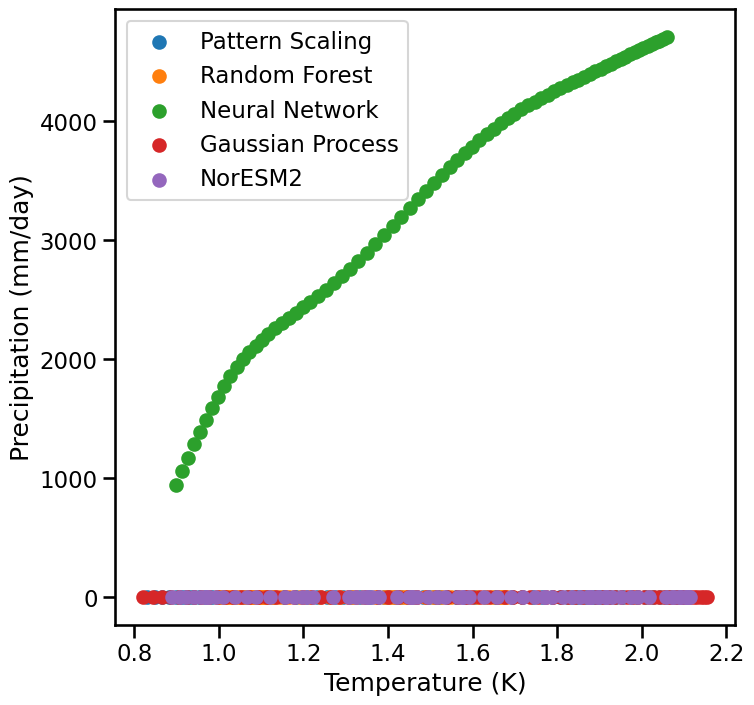

In [26]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas']).rolling(time=10, center=True).mean(), global_mean(model['pr']).rolling(time=10, center=True).mean(), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()

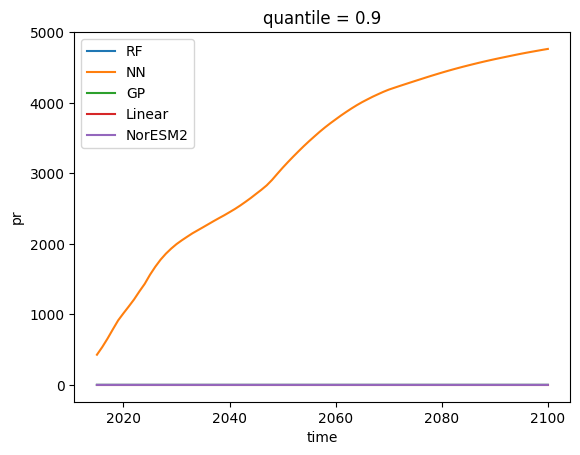

In [27]:
global_mean(rf_predictions['pr']).plot(label='RF')
global_mean(nn_predictions['pr']).plot(label='NN')
global_mean(gp_predictions['pr']).plot(label='GP')
global_mean(linear_predictions['pr']).plot(label='Linear')
global_mean(Y['pr'].mean('member')).plot(label='NorESM2')
plt.legend()

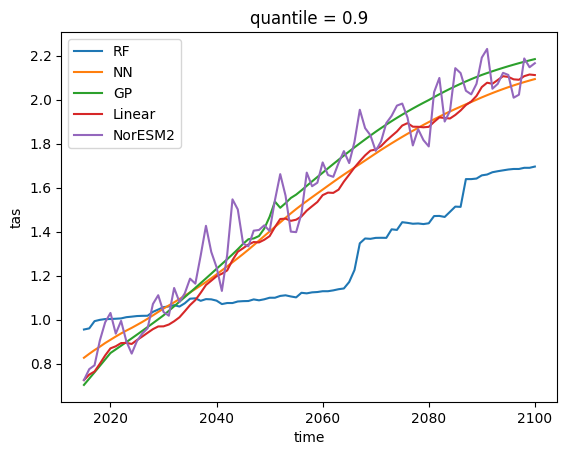

In [28]:
global_mean(rf_predictions['tas']).plot(label='RF')
global_mean(nn_predictions['tas']).plot(label='NN')
global_mean(gp_predictions['tas']).plot(label='GP')
global_mean(linear_predictions['tas']).plot(label='Linear')
global_mean(Y['tas'].mean('member')).plot(label='NorESM2')
plt.legend()

Pattern Scaling slope: 0.9918549186126323 intercept: 1.3322676295501878e-15
Random Forest slope: 0.8605008319251912 intercept: -0.4351089787652982
Neural Network slope: 129214.94495911695 intercept: -53284.10195533637
Gaussian Process slope: 1.7577768200738229 intercept: -1.90170012268633
NorESM2 slope: 2.2828011493051084 intercept: -2.0263267634750637


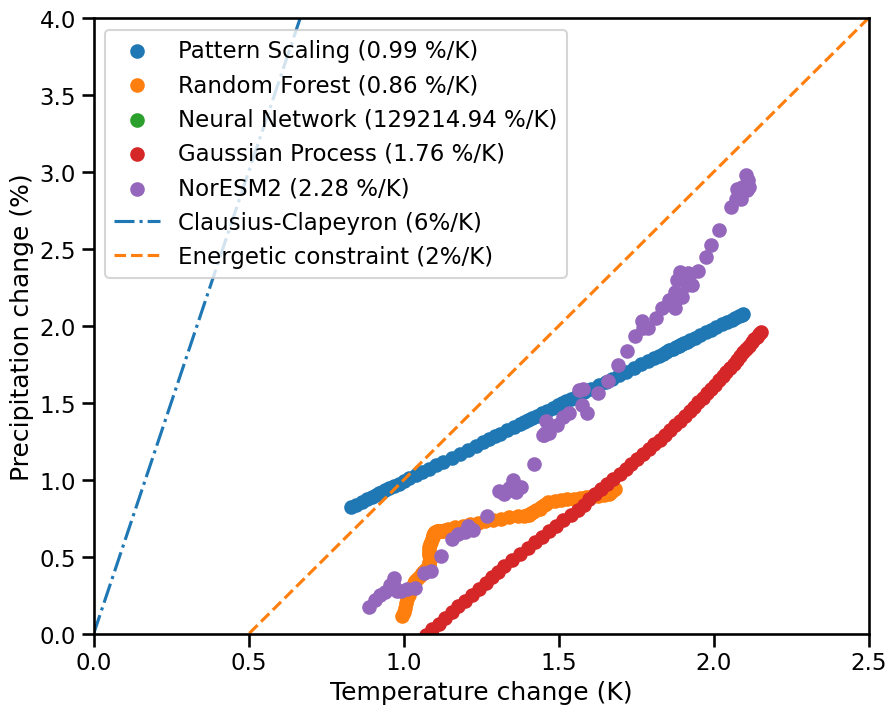

In [30]:
from sklearn.linear_model import LinearRegression

baseline_precip = 2.33511687 # From piControl

# with sns.plotting_context("talk"):
    
#     x = np.linspace(0, 2.5, 100)
    
#     m=LinearRegression().fit(x[:, np.newaxis], x*2-1)
#     print("{} slope: {} intercept: {}".format('Energetic', m.coef_, m.intercept_))

#     fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#     for model, model_label in zip(models, model_labels):
#         # Calculate the smoothed global mean for each model
#         smooth = global_mean(model['tas']).rolling(time=10).mean().dropna('time')
#         x_ = smooth
#         y_ = (global_mean(model['pr']).rolling(time=10).mean() / baseline_precip * 100).dropna('time')
        
#         # Ensure x_ and y_ are 1D arrays
#         if x_.ndim > 1:
#             x_ = x_.squeeze()  # Squeeze to 1D
#         if y_.ndim > 1:
#             y_ = y_.squeeze()  # Squeeze to 1D
    
#         # Check dimensions
#         if x_.ndim != 1 or y_.ndim != 1:
#             raise ValueError("x_ and y_ must be 1D arrays")
        
#         # Fit the linear model
#         m = LinearRegression().fit(x_[:, np.newaxis], y_.data)

#         s=ax.scatter(x_.sel(time=slice(2050, None)), y_.sel(time=slice(2050, None)), label="{} ({:0.2} %/K)".format(model_label, m.coef_[0]))
#         ax.scatter(x_.sel(time=slice(None, 2050)), y_.sel(time=slice(None, 2050)), facecolor='w', edgecolor=s.get_facecolor())
#         print("{} slope: {} intercept: {}".format(model_label, m.coef_, m.intercept_))
    
#     plt.plot(x, x*6, label="Clausius-Clapeyron (6%/K)", ls='-.')
#     plt.plot(x, x*2-1, label="Energetic constraint (2%/K)", ls='--')
    
#     plt.setp(plt.gca(), xlabel="Temperature change (K)", ylabel="Precipitation change (%)", xlim=[0, 2.5], ylim=[0, 4])
#     plt.legend(loc='upper left')
    
#     plt.savefig("Figure_6.pdf")
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    x = np.linspace(0, 2.5, 100)  # Range of temperature changes
    
    for model, model_label in zip(models, model_labels):
        # Calculate smoothed global means
        tas_smooth = global_mean(model['tas']).rolling(time=10, center=True).mean().dropna('time')
        pr_smooth = (global_mean(model['pr']) / baseline_precip * 100).rolling(time=10, center=True).mean().dropna('time')

        # Ensure tas_smooth and pr_smooth are 1D arrays
        tas_smooth = tas_smooth.squeeze()
        pr_smooth = pr_smooth.squeeze()
        # Fit Linear Regression
        # Fit Linear Regression
        if tas_smooth.ndim == 1:
            # Convert to numpy array before reshaping to avoid indexing issues
            tas_smooth_reshaped = tas_smooth.values[:, np.newaxis]
        else:
            tas_smooth_reshaped = tas_smooth.values
        
        m = LinearRegression().fit(tas_smooth_reshaped, pr_smooth.values)


        # Plotting
        s = ax.scatter(tas_smooth, pr_smooth, label=f"{model_label} ({m.coef_[0]:.2f} %/K)")
        
        # Print the slope and intercept
        print(f"{model_label} slope: {m.coef_[0]} intercept: {m.intercept_}")
        
    # Plot Clausius-Clapeyron and Energetic constraint lines
    ax.plot(x, x*6, label="Clausius-Clapeyron (6%/K)", ls='-.')
    ax.plot(x, x*2-1, label="Energetic constraint (2%/K)", ls='--')
    
    # Set plot parameters and legend
    ax.set_xlabel("Temperature change (K)")
    ax.set_ylabel("Precipitation change (%)")
    ax.set_xlim([0, 2.5])
    ax.set_ylim([0, 4])
    ax.legend(loc='upper left')
    
    # Save the figure
    plt.savefig("Figure_6.pdf")

In [31]:
from xskillscore import rmse, pearson_r, spearman_r, r2, smape, mae, me, mse

weights = np.cos(np.deg2rad(Y['tas'].lat)).expand_dims(lon=144).assign_coords(lon=Y.lon)

In [32]:
# Print basic statistics for each variable
print("Basic Statistics for Each Variable:")
for var in Y.data_vars:
    print(f"Variable: {var}")
    print(Y[var].to_dataframe().describe())
    print("\n")


Basic Statistics for Each Variable:
Variable: diurnal_temperature_range
           quantile  diurnal_temperature_range
count  3.566592e+06               3.566592e+06
mean   9.000000e-01              -8.844225e-02
std    5.734025e-11               3.582314e-01
min    9.000000e-01              -3.706241e+00
25%    9.000000e-01              -2.240140e-01
50%    9.000000e-01              -1.911545e-02
75%    9.000000e-01               5.739178e-02
max    9.000000e-01               4.285817e+00


Variable: tas
           quantile           tas
count  3.566592e+06  3.566592e+06
mean   9.000000e-01  1.847543e+00
std    5.734025e-11  1.551763e+00
min    9.000000e-01 -4.675842e+00
25%    9.000000e-01  8.170776e-01
50%    9.000000e-01  1.518921e+00
75%    9.000000e-01  2.487213e+00
max    9.000000e-01  1.210977e+01


Variable: pr
           quantile            pr
count  3.566592e+06  3.566592e+06
mean   9.000000e-01  5.052885e-02
std    5.734025e-11  7.866382e-01
min    9.000000e-01 -9.667351e+0

In [33]:
# Rename 'diurnal_temperature_range' to 'dtr' in Y
Y = Y.rename({'diurnal_temperature_range': 'dtr'})

R2E = pd.DataFrame({
    label: {variable: rmse( global_mean(Y.mean('member')[variable].sel(time=slice(2080, None))), 
                                global_mean(model[variable].sel(time=slice(2080, None)))).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
#                                 global_mean(model[variable].sel(time=slice(2080, None)))).data for variable in variables} 
                           for label, model in zip(model_labels[:-1], models[:-1])
})
R2E.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

In [34]:
# NRMSE = pd.DataFrame({
#     label: {variable: rmse(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
#                                model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
#     for label, model in zip(model_labels[:-1], models[:-1])
# })
# NRMSE.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

NRMSE = pd.DataFrame({
    label: {
        variable: rmse(
            model[variable].sel(time=slice(2080, None)).mean('time').rename({'latitude': 'lat', 'longitude': 'lon'}),
            Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'),
            weights=weights
        ).data / np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data)
        for variable in variables
    } 
    for label, model in zip(model_labels[:-1], models[:-1])
})
NRMSE.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

In [35]:
(NRMSE+5*R2E).T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

In [36]:
combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total'])[model_labels[3::-1]].T.swaplevel(axis=1)[variables]

In [37]:
combined_df.style.highlight_min(subset=slice(None, "Random Forest"), axis = 0, props='font-weight: bold').format("{:.3f}")

In [38]:

R2E = pd.DataFrame({
    "Variability": {variable: global_mean(Y[variable].sel(time=slice(2080, None))).std().data / np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
})

NRMSE = pd.DataFrame({
    "Variability": {variable: global_mean(Y[variable].sel(time=slice(2080, None)).mean('time').std('member')).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables}
})

variability_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total']).T.swaplevel(axis=1)[variables]


In [39]:
CMIP6_df = variability_df.copy().rename(dict(Variability='CMIP6'))
CMIP6_df.T['CMIP6'] = np.NaN

In [40]:
all_df = pd.concat([combined_df, variability_df, CMIP6_df])
all_df.style.highlight_min(subset=slice(None, "Random Forest"), axis = 0, props='font-weight: bold').format("{:.3f}")

# Idealised experiment results

In [41]:
# Get one combined historical + ssp585 timeseries for now
alt_Y = xr.open_dataset(data_path + 'outputs_ssp245-aer.nc')

# Convert the precip values to mm/day
alt_Y["pr"] *= 86400
alt_Y["pr90"] *= 86400

FileNotFoundError: [Errno 2] No such file or directory: '/home/cauliflower/ClimateBench/outputs_ssp245-aer.nc'

In [ ]:
rf_predictions = xr.open_dataset(data_path + "/revisions_2/" + 'outputs_ssp245_prediction_ESEm-aer.nc').swap_dims(sample='time')
rf_predictions = rf_predictions.assign_coords(time=rf_predictions.time+1)  # I don't really know why this is off...

linear_predictions = xr.open_dataset(data_path + '/revisions_2/'+'outputs_ssp245_prediction_pattern2-aer.nc')
nn_predictions = xr.merge([{v: xr.open_dataarray(data_path +'/revisions_2/'+ "outputs_ssp245_predict_{}-aer.nc".format(v))} for v in variables])
gp_predictions = xr.merge([{v: xr.open_dataarray(data_path + '/revisions_2/'+"climatebench-gp-posterior-mean-{}-test-aer-2019-2100.nc".format(v))} for v in variables])

In [ ]:
# Convert the precip values to mm/day
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

In [ ]:
models = [linear_predictions, rf_predictions, nn_predictions, gp_predictions, alt_Y.mean('member')]
model_labels = ['Linear', 'Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-2, vmax=2), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

In [ ]:
# with sns.plotting_context("talk"):

# #     fig = plt.figure()
#     fig, axes = plt.subplots(4, 4, subplot_kw=dict(projection=proj), figsize=(30, 18), constrained_layout=True)
#     print(axes)
#     for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
#         for ax, model, model_label in zip(model_axes, models[1:], model_labels[1:]):
# #             if label == 'Temperature (K)':
#             ax.set_title(model_label)
#             if model_label == 'NorESM2':
#                 model[var].sel(time=slice(2080, 2100)).mean(['time']).plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
#             else: 
#                 model[var].sel(time=slice(2080, 2100)).mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
#             ax.coastlines()
                

In [ ]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

# proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]


with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models[1:-1], model_labels[1:-1]):
#             if label == 'Temperature (K)':
            ax.set_title(model_label)
            diff = (model[var]-models[-1][var]).sel(time=slice(2080, 2100)) # /models[-1][var]
            mean_diff = diff.mean('time')
            _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
#             p=0
            if model_label == 'Gaussian Process':
                mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else:
                mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            
            ax.coastlines()
                
    plt.savefig("Figure_A3.pdf")

In [ ]:
from sklearn.linear_model import LinearRegression

baseline_precip = 2.33511687 # From piControl

with sns.plotting_context("talk"):
    
    x = np.linspace(-1, 2.5, 100)
    
    m=LinearRegression().fit(x[:, np.newaxis], x*2-1)
    print("{} slope: {} intercept: {}".format('Energetic', m.coef_, m.intercept_))

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    for model, model_label in zip(models[1:], model_labels[1:]):
        smooth = global_mean(model).rolling(time=10).mean().dropna('time')
        smooth = global_mean(model).coarsen(time=5, boundary='pad').mean().dropna('time')
        x_, y_ = smooth['tas'], smooth['pr']/baseline_precip*100
        m=LinearRegression().fit(x_.data[:, np.newaxis], y_)

        s=ax.scatter(x_.sel(time=slice(2080, None)), y_.sel(time=slice(2080, None)), label="{} ({:0.2} %/K)".format(model_label, m.coef_[0]))
        ax.scatter(x_.sel(time=slice(None, 2080)), y_.sel(time=slice(None, 2080)), facecolor='w', edgecolor=s.get_facecolor())
        print("{} slope: {} intercept: {}".format(model_label, m.coef_, m.intercept_))
    
    plt.plot(x, x*6, label="Clausius-Clapeyron (6%/K)", ls='-.')
    plt.plot(x, x*2-1, label="Energetic constraint (2%/K)", ls='--')
    
    plt.setp(plt.gca(), xlabel="Temperature change (K)", ylabel="Precipitation change (%)", xlim=[-1, 0.5], ylim=[-3, 1])
    plt.legend(loc='upper left')

In [ ]:

R2E = pd.DataFrame({
    label: {variable: rmse( global_mean(alt_Y.mean('member')[variable].sel(time=slice(2080, None))), 
                                global_mean(model[variable].sel(time=slice(2080, None)))).data/ np.abs(global_mean(alt_Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
    for label, model in zip(model_labels[1:-1], models[1:-1])
})
R2E.T.round(3).style.highlight_min(axis = 0, props='font-weight: bold').format("{:.4f}")

In [ ]:
NRMSE = pd.DataFrame({
    label: {variable: rmse(alt_Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data/ np.abs(global_mean(alt_Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
    for label, model in zip(model_labels[1:-1], models[1:-1])
})
NRMSE.T.round(3).style.highlight_min(axis = 0, props='font-weight: bold').format("{:.4f}")

In [ ]:
(NRMSE+5*R2E).T.round(3).style.highlight_min(axis = 0, props='font-weight: bold').format("{:.4f}")

In [ ]:
model_labels[3:0:-1]

In [ ]:
combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total'])[model_labels[3:0:-1]].T.swaplevel(axis=1)[variables]

In [ ]:
combined_df.style.highlight_min(axis = 0, props='font-weight: bold').format("{:.3f}")